In [1]:
import PySpice.Spice.Simulation
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = 'ngspice-shared'

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# Single nfet creation

In [2]:
def sky130_circuit(cell, vdd, w, l):
  circuit = Circuit('nfet_01v8')
    #path needs to be adjusted, but the sky130.lib.spice file is what you need!  
  circuit.lib('pySpiceLibrary/skywater-pdk/libraries/sky130_fd_pr/latest/models/sky130.lib.spice', 'tt')
  Vgate = circuit.V('gate', 'vg', circuit.gnd, 0@u_V)
  Vdrain = circuit.V('drain', 'vdd', circuit.gnd, u_V(vdd))
  circuit.X('cell', cell, 'vdd', 'vg', circuit.gnd, circuit.gnd, w=w, l=l)
  return circuit

circuit = sky130_circuit('sky130_fd_pr__nfet_01v8', 1.8, w=10, l=1.15)
print(str(circuit))

.title nfet_01v8
.lib /PIACC/pySpiceLibrary/skywater-pdk/libraries/sky130_fd_pr/latest/models/sky130.lib.spice tt
Vgate vg 0 0V
Vdrain vdd 0 1.8V
Xcell vdd vg 0 0 sky130_fd_pr__nfet_01v8 l=1.15 w=10



# Simulation bloc

In [3]:
import PySpice.Spice.Simulation
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = 'ngspice-shared'

def sky130_simulate_dc(cell, sweep, **kwargs):
  circuit = sky130_circuit(cell, sweep.stop, **kwargs)
  simulator = circuit.simulator(temperature=25, nominal_temperature=25)
  analysis = simulator.dc(Vgate=sweep)
  vgs = analysis['vg']
  id = u_mA(-analysis.Vdrain)
  return (vgs, id)

In [4]:
vgs, id = sky130_simulate_dc('sky130_fd_pr__nfet_01v8',
                             sweep=slice(0, 1.8, .01),
                             w=10, l=0.15)

spinit was not found
Note: can't find init file.
Unsupported Ngspice version 36


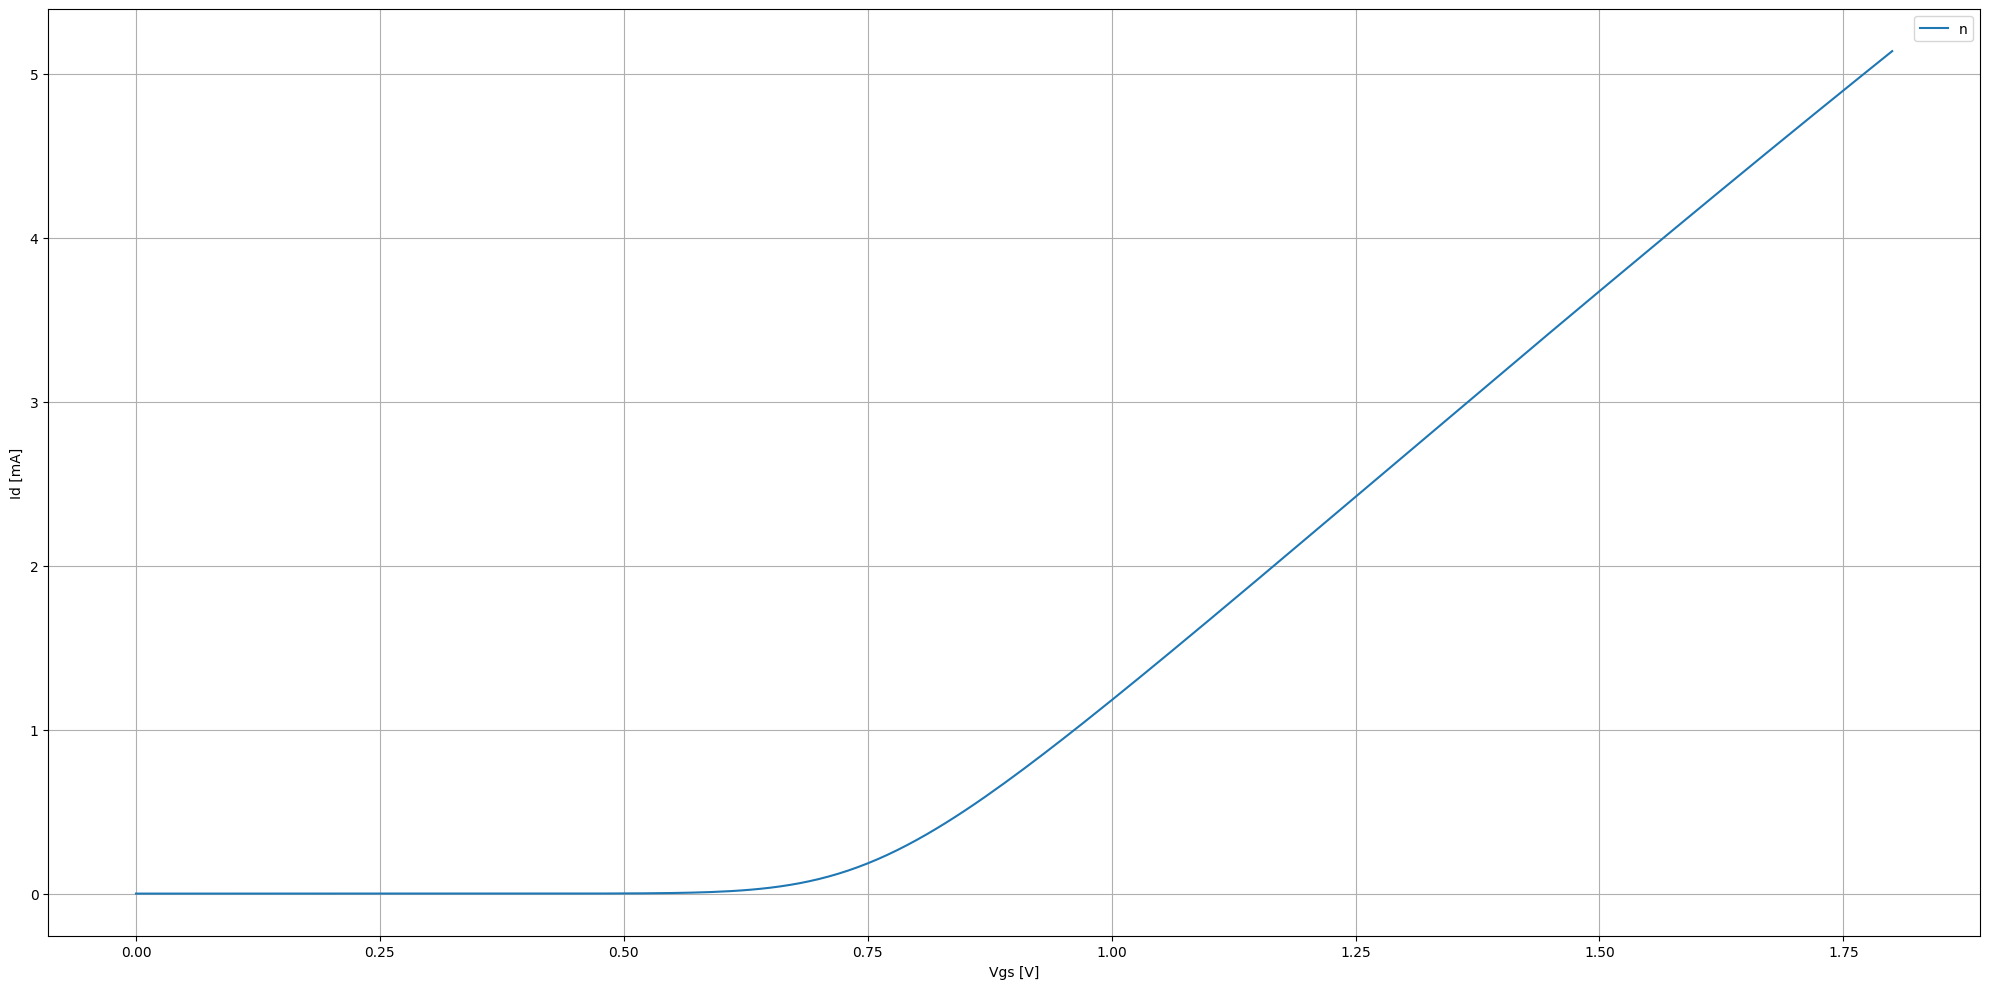

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

figure, ax = plt.subplots(figsize=(20, 10))
ax.plot(vgs, id)
ax.legend('nfet_01v8')
ax.grid()
ax.set_xlabel('Vgs [V]')
ax.set_ylabel('Id [mA]')
plt.tight_layout()
plt.show()

# multiplot example

In [6]:
%matplotlib inline
import itertools
import numpy as np
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import PySpice.Math.Calculus

In [7]:
def sky130_simulate_dc(cell, bias, sweep, w, l):
  circuit = sky130_circuit(cell, bias, w=w, l=l)
  simulator = circuit.simulator(temperature=25, nominal_temperature=25)
  analysis = simulator.dc(Vgate=sweep)
  vgs = analysis['vg']
  id = u_mA(-analysis.Vdrain)
  return (vgs, id)

  0%|          | 0/6 [00:00<?, ?it/s]

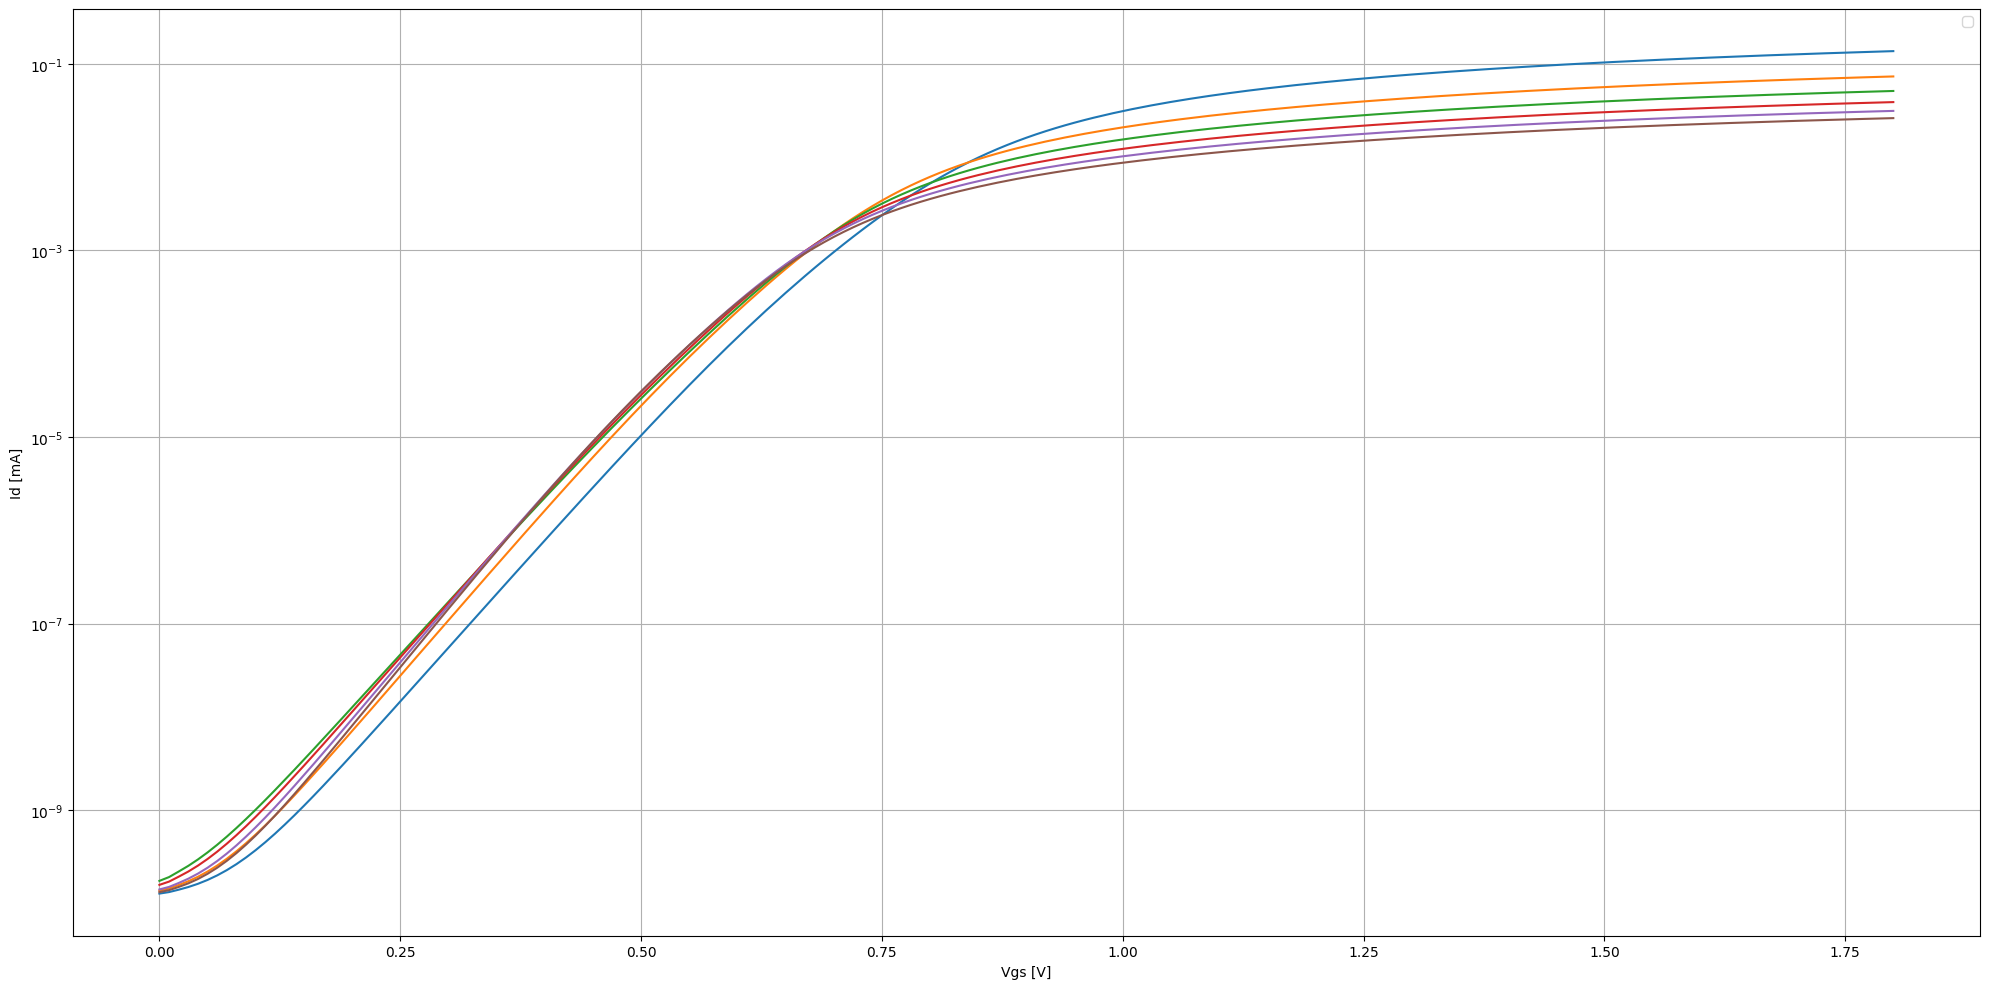

In [8]:
ws = [1]
ls = np.arange(0.15, 1, 0.15)

figure, ax = plt.subplots(figsize=(20, 10))
ax.legend('nfet_01v8')
ax.grid()
ax.set_xlabel('Vgs [V]')
ax.set_ylabel('Id [mA]')
ax.set_yscale('log')

for w, l in tqdm.tqdm(itertools.product(ws, ls), total=len(ws)*len(ls)):
  vgs, id = sky130_simulate_dc('sky130_fd_pr__nfet_01v8',
                               bias=0.1,
                               sweep=slice(0, 1.8, .01),
                               w=w, l=l)
  #ddid = PySpice.Math.Calculus.derivative(vgs, id, 2)
  ax.plot(vgs, id)

plt.tight_layout()
plt.show()

# Run OP simulations across device parameters sweep

In [9]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import tqdm.notebook as tqdm
import pandas as pd

def sky130_simulate_op(cell, bias, ws, ls):
  for w, l in itertools.product(ws, ls):
    circuit = sky130_circuit(cell, bias, w=w, l=l)
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()
    id = u_mA(-analysis.Vdrain)
    yield w, l, float(id[0])

ws = [10]
ls = [0.15, 0.17, 0.18, 0.19, 0.24, 0.25, 0.26, 0.4, 0.5, 0.6, 0.9, 1, 1.1, 1.9, 2, 2.1, 3.9, 4, 4.1, 7, 8, 9, 15, 20, 25, 90, 100]

values = tqdm.tqdm(
    sky130_simulate_op('sky130_fd_pr__nfet_01v8', 1.8, ws, ls),
    total=len(ws)*len(ls)
)
values = list(values)
df = pd.DataFrame.from_records(values, columns=('W', 'L', 'ID'))
df

  0%|          | 0/27 [00:00<?, ?it/s]

,W,L,ID
0,10,0.15,2.419442e-12
1,10,0.17,3.851131e-12
2,10,0.18,4.336873e-12
3,10,0.19,4.701383e-12
4,10,0.24,3.068402e-12
5,10,0.25,2.854586e-12
6,10,0.26,2.871755e-12
7,10,0.40,2.861234e-12
8,10,0.50,2.773280e-12
9,10,0.60,2.699133e-12


<Axes: xlabel='L [uM] (log)', ylabel='Id [mA] (log)'>

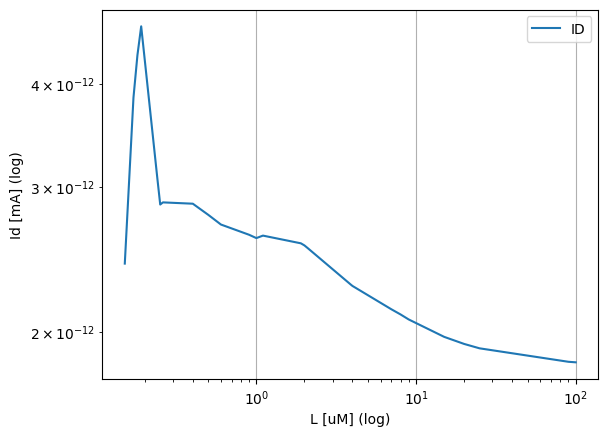

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

ax = df.plot(x='L', y='ID')
ax.grid()
ax.set_xlabel('L [uM] (log)')
ax.set_ylabel('Id [mA] (log)')
ax.set_xscale('log')
ax.set_yscale('log')
ax